In [1]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


The central idea is to start from the $\alpha$ and $\psi$ of Schwarzschild, and gradually add multiple $\delta \rho$'s to it to obtain the TOV solution

### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [3]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Downsample the data
downsample_factor = 2000
m     = m[::downsample_factor]
P     = P[::downsample_factor]
rho   = rho[::downsample_factor]
R     = R[::downsample_factor]
alpha = alpha[::downsample_factor]
psi   = psi[::downsample_factor]

# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P


## 1. Application of a perturbation to the density

In [9]:
# Definitions
iteration_steps = 5000

# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-1     # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
rho_perturbation = gaussian * R_centered

# Define the perturbed density
perturbed_rho = rho + rho_perturbation
perturbed_rho = rho

### 2. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

We focus immediately on the nonlinear ODE:
\begin{equation}
\nabla^{2} \psi = \frac{S_{1}}{\psi} + \frac{S_{7}}{\psi^7}
\end{equation}
which we will solve in an iterative fashion as we will compute $\psi_{(n+1)}$ in iteration $n+1$ based on the previous estimate $\psi_{(n)}$ in iteration $n$:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}} + \frac{S_{7}}{\psi_{(n)}^7}
\end{equation}
Assume we know the solution $\psi$ for a given density $\rho$. We are now interested in $\psi$ for a perturbed density, that is, for $\rho_{perturbed} = \rho + \delta \rho$. This leads to the source terms:
\begin{align}
    S_1   &= -2 \pi \rho_{perturbed} \\ 
    S_7   &= 0 \\
\end{align}
such that the nonlinear ODE now reads:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
In spherical symmetry, this ODE reads:
\begin{equation}
    \big( \partial_{r}^{2} + \frac{2}{r} \partial_r \big) \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
It should satisfy the following boundary conditions:
\begin{align}
    \frac{d\psi}{dr}(0) &= 0 \\
    \psi(R) &= 1 + C/R_{max} 
\end{align}
We initialize $\psi_{(0)}$ with the initial $\psi$ for the density $\rho$, and update this estimate along the way. In each iteration $n$, we will compute a posterior distribution over $\psi_{(n)} \sim \mathcal{N}(\mu_{(n)}, \Sigma_{(n)})$. The uncertainty propogates to an uncertainty in the right-hand side, which we compute through a linearization of the source term:
\begin{equation}
    \frac{S_{1}}{\psi} \approx \frac{S_{1}}{\psi_{(n)}} - \frac{S_{1}}{\psi_{(n)}^2} \delta \psi_{(n)}
\end{equation}
such that the covariance on the source term at iteration $n$, $S_{n}$, is increased:
\begin{equation}
    S_{(n+1)} \leftarrow S_{(n)} + \bigg( \frac{1}{\psi_{(n)}^2} (S_{1} \Sigma_{(n)} S_{1}^T) (\frac{1}{\psi_{(n)}^2}) \bigg)^T 
\end{equation}

In [10]:
# Definition of the source term S1
S1 = - 2*np.pi*perturbed_rho

# Symbol nomenclature
r     = sp.symbols('r')
n     = sp.symbols('n')
R_max = sp.symbols('R_max')

# Definition of the basis functions
basis_func       = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)

# Definition of the laplacian operator
laplacian = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))


In [11]:
# Function definitions
# 1a. Construction of the design matrix
def construct_design_matrix(S1, R, basis_func_lamb, laplacian_lambd, psi, N):
    # Definition of k_squared and the source term
    source_term = S1 / psi
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(R), N))
    basis_func_matrix = np.zeros((len(R), N))
    
    for i in range(1, N):
        design_matrix[:,i] = laplacian_lambd(R, i, max(R))
        basis_func_matrix[:,i] = basis_func_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix, source_term

# 1b. Construction of the design matrix for Chebyshev polynomials
def construct_design_matrix_chebyshev(S1, R, psi, N):
    # Definition of k_squared and the source term
    source_term = S1 / psi
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(R)+2, N))     # +2 due to the boundary conditions
    basis_func_matrix = np.zeros((len(R), N))

    # Currently take it from start_order 3 to avoid that the operator on the basis function yields 0
    min_order = 3
    for i in range(min_order, N+min_order):
        # This can be implemented much more efficiently by precomputing this
        basis_func = sp.polys.orthopolys.chebyshevt_poly(i, r/R_max)
        basis_func_lambd = sp.lambdify((r, R_max), basis_func)
        laplacian_lambd = sp.lambdify((r, R_max), sp.simplify(laplacian(r, basis_func)))

        # Boundary condition at the origin
        diff_basis_func = sp.diff(basis_func, r)
        diff_func_lambd = sp.lambdify((r, R_max), diff_basis_func)
        BC1 = np.array([diff_func_lambd(np.min(R), np.max(R))])

        # Boundary condition at the outer point
        BC2 = np.array([basis_func_lambd(np.max(R), np.max(R))])
        
        design_matrix[:,i-min_order] = np.hstack((laplacian_lambd(R, max(R)), BC1, BC2))
        basis_func_matrix[:,i-min_order] = basis_func_lambd(R, max(R))

    return basis_func_matrix, design_matrix, source_term


# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, y, S, L):
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S, -2)
    Lneg2 = np.linalg.matrix_power(L, -2)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ y
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    source_func_variance_primal = np.diag(source_func_variance_primal)
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(A, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v
    solution_variance_primal = np.diag(solution_variance_primal)

    return solution_mean_primal, solution_variance_primal, solution_variance_primal, w, v


In [12]:
psi_init = np.random.normal(1, 2, size=psi.shape)
N = 25                               # Number of basis functions
S = 1.0e-4*np.identity(len(R)+2)     # Sigma matrix
L = 1.0e2*np.identity(N)             # 

# Define the arrays which store the variables
iteration_steps        = 5
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
delta_psi_mean_storage = np.zeros((len(psi), iteration_steps+1))
delta_psi_var_storage  = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC1 = 0
y_BC2 = np.array([1 + m[-1]/(2*R[-1])])

for i in tqdm(range(1, iteration_steps)):

    basis_func_matrix, design_matrix, source_term = construct_design_matrix_chebyshev(S1, R, psi_mean_storage[:, i-1], N);
    
    source_term = np.hstack((source_term, 0, y_BC2))
    
    solution_mean_primal, solution_variance_primal, solution_variance_primal, w, v = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)

    psi_mean_storage[:, i] = solution_mean_primal



00%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]

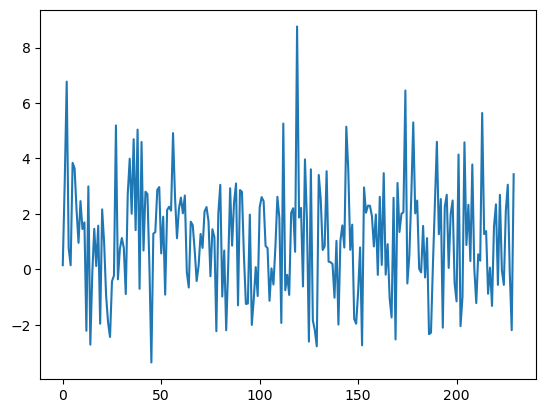

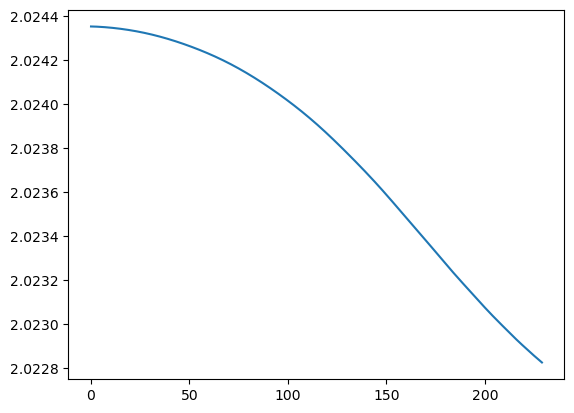

In [14]:
plt.figure(1)
plt.plot(psi_mean_storage[:,0])

plt.figure(2)
plt.plot(psi_mean_storage[:,4])

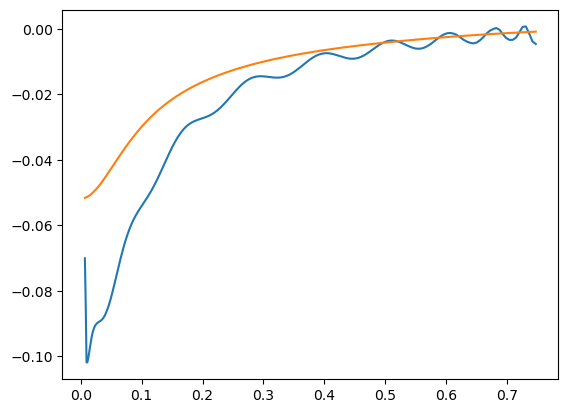

In [21]:
first_gradient = np.gradient(psi_mean_storage[:,4],R)
second_gradient = np.gradient(first_gradient,R)

plt.plot(R, second_gradient + 2/R*first_gradient)
plt.plot(R, S1/psi)